In [2]:
import pandas as pd
import numpy as np
import pickle
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path

In [3]:
# Load data
cwd = Path.cwd()
moondf = pickle.load(open(cwd / '..' / 'raw_data' / 'moonGen_scrape_2016_with_labels', 'rb'))
# change the grade column from a number 4 - 14 to a list of 11 binary values
moondf['grade'] = moondf['grade'].apply(lambda x: [1 if i == x else 0 for i in range(4, 15)])
# one hot encode the grade column
grade_cols = ['V_' + str(i) for i in range(4, 15)]
moondf[grade_cols] = pd.DataFrame(moondf['grade'].to_list(), index=moondf.index)
y = moondf[grade_cols].values
X = moondf.drop(columns=grade_cols, axis=1)
X = X.drop(["is_benchmark", "repeats", "grade"], axis=1).values

In [4]:

# Now train a neutral network on the same data (using keras)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Input(shape=(141,)))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(11, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)

estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)


2023-11-30 13:31:35.654488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/yv/3g8ggfl9341blgk0mn8sq6_c0000gn/T/ipykernel_65148/2580341340.py:30: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
2023-11-30 13:31:39.147952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operatio

Accuracy: 42.32%


Text(0.5, 1.0, 'Confusion Matrix for FCNN Classifier')

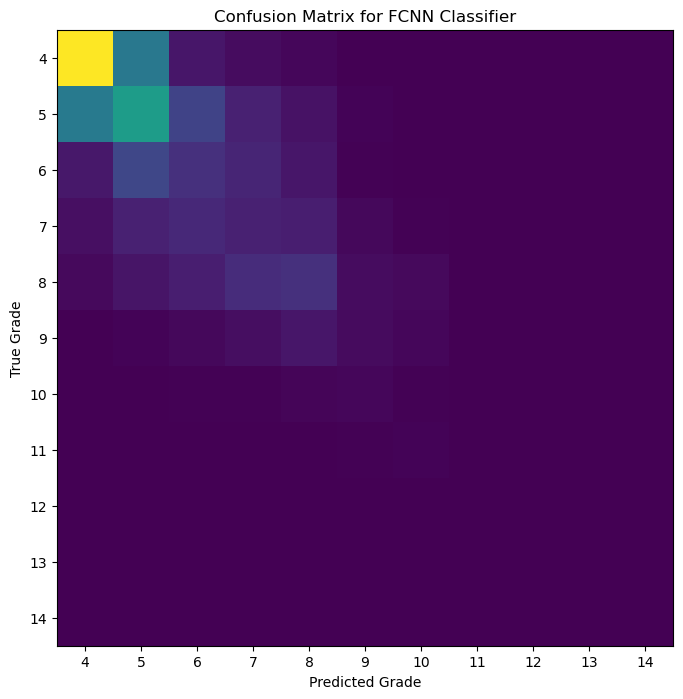

In [9]:
accuracy = sklearn.metrics.accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
fig = plt.figure(figsize=(8, 8))
plt.imshow(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
plt.xticks(np.arange(11), np.arange(4, 15))
plt.yticks(np.arange(11), np.arange(4, 15))
plt.xlabel('Predicted Grade')
plt.ylabel('True Grade')
plt.title('Confusion Matrix for FCNN Classifier')